# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [ ]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
# NOTE: The above statement seems non-sensible - 
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# QUESTION: If image has been converted to gray, why is the cmap='gray' needed?
# ANSWER: without the gray specified, one gets a very strange color palette with the image reduced to yellows, blues, and reds
#         probably be useful to go read about cv2 in more depth.  For now, just use it
print("image_gray\n")
plt.imshow(image_gray, cmap='gray') 


In [ ]:
# do the Gaussian blur thing
kernel_size = 3     # was 11 in quizzes
blur_gray = cv2.GaussianBlur(image_gray, (kernel_size, kernel_size), 0)
print("blur_gray\n")
plt.imshow(blur_gray, cmap='gray')

In [ ]:
# Define our parameters for Canny and apply
low_threshold = 55
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(imshape[1]/16,imshape[0]),
    (31*imshape[1]/64, 19*imshape[0]/32), 
    (33*imshape[1]/64, 19*imshape[0]/32), 
    (15*imshape[1]/16,imshape[0])]], 
    dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

plt.imshow(masked_edges, cmap='gray')



In [ ]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 13    # minimum number of votes (intersections in Hough grid cell)
min_line_length = 3 #minimum number of pixels making up a line
max_line_gap = 7    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
plt.imshow(line_image)

# Create a "color" binary image to combine with line image
# This is a total red herring
# color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(image, 0.6, line_image, 1, 0) 
plt.imshow(lines_edges)



**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import sys
import os
import time
from enum import Enum

%matplotlib inline

In [4]:
#
# Helper Functions
#
class props (Enum):
    num = 0
    total = 1
    ave = 2
    min_yx = 3
    max_yx = 4
    
def calc_new_lines(pos_line, neg_line, pos_slope, neg_slope, y_min, y_max):
    # lines must both reach from max_y to min_y along their appropriate slope
    # First identify the line that has the y_min, and save that point pair.
    #     That line only needs the new x calculated (how it is calculated
    #         depends on whether it is the right or left line)
    # Then for the other line, both ends need to be extended using the 
    #     closest existing point and the appropriate y_min or y_max, again
    #     this depends on whether it is the right or left line)
    # LEFT LINE (neg_line): [neg_x_min, y_max, neg_x_max_1, y_min]
    # RIGHT LINE (pos_line): [pos_x_min, y_min, pos_x_max, y_max]
    # (yes, it is confusing, graph it on an image plot and it makes more sense)
    #
    # *** print("      calc_new_lines: pos_line: ", pos_line,", pos_slope: ", pos_slope)
    # *** print("      calc_new_lines: neg_line: ", neg_line,", pos_slope: ", neg_slope)
    # *** print("      min, max y", y_min, ", ", y_max)
    
    new_lines = []
    neg_x_min = 0
    neg_x_max = 0
    pos_x_min = 0
    pos_x_max = 0
    new_pos_line = []
    new_neg_line = []
    #
    # The lEFT line has the negative slope, the RIGHT line has the positive slope
    # Determine which of these lines has the min point.  
    #
    # If it is the LEFT line that would be neg_x_max, y_min.  
    # If it is the RIGHT line, it would be pos_x_min, y_min.
    #
    # Whichever line has the min point (horizon point) only needs extension on the opposite end
    # to the y_max (aka 540).  This extension is done from the closest found point to the y_max point
    # allowing us to use the equation x_whatever = ((y2 - y1)/m) + or minus the known x value depending 
    # on whether it is x1(+), or x2(-, but then we multiply by -1 because we get the negative of the 
    # desired point - look at the math)
    #
    # The remaining line will need extension from both ends, using the closest known point as the source
    # for the x & y values in the equation.
    #
    if (y_min == pos_line[1]):
        # we know pos_line[0]:(x1), y_min:(y1), so we only need to solve for pos_x_max:(x2), y_max:(y2)
        # *** print ("      calc_new_lines: pos line has y_min: ", pos_line, " neg_line: ", neg_line)
        # Use the closest point for extrapolation, so use pos_line[2]:(x1), pos_line[3]:(y1), y_max:(y2)
        pos_x_min = pos_line[2]
        pos_x_max = solve_for_x(pos_x_min, pos_line[3], y_max, pos_slope, False)
        new_pos_line = [ pos_line[0], y_min, pos_x_max, y_max ]
        # *** print("calc_new_lines: new pos_x_max", pos_x_max, "existing line: ", pos_line, "new line: ", new_pos_line)
        # Now the neg_line needs to be extended at both ends - bottom end to neg_x_min, y_max, top end to neg_x_max, y_min
        # first extension solves for neg_x_min:(x1), neg_line[0]:(x2), using y_max:(y1), neg_line[1]:(y2)
        neg_x_min = solve_for_x(neg_line[0], y_max, neg_line[1], neg_slope, True)
        # second extension solves for neg_x_max:(x2), using neg_line[2]:(x1), neg_line[3]:(y1), y_min:(y2)
        neg_x_max = solve_for_x(neg_line[2], neg_line[3], y_min, neg_slope, False)
        new_neg_line = [ neg_x_min, y_max, neg_x_max, y_min]
        # *** print ("calc_new_lines: neg_line: ",neg_line," new_neg_line: ",new_neg_line)
    else:    
        # so we know the neg_line has the y_min, which means the min_y is at neg_x_max:neg_line[2], min_y:neg_line[3]
        # THIS CODE GETS TESTED IN A DIFFERENT IMAGE WHERE THE LEFT LINE IS SOLID...IF I CAN GET THAT FAR!!!
        #
        # *** print ("calc_new_lines: neg line has y_min: ", pos_line, " neg_line: ", neg_line)
        neg_x_max = neg_line[2]
        neg_x_min = solve_for_x(neg_x_max, y_min, y_max, neg_slope, True)
        new_neg_line = [neg_x_min, y_max, neg_x_max, y_min]
        # *** print("      calc_new_lines: new neg_x_min", neg_x_min, "existing line: ", neg_line, "new line: ", new_neg_line)
        # Now the pos_line needs to be extended at both ends - top end to pos_x_min, y_min, bottom end to pos_x_max, y_max
        # first extension solves for pos_x_min:(x1), using y_min:(y1), pos_line[0]:(x2), pos_line[1]:(y2)
        pos_x_min = solve_for_x(pos_line[0], y_min, pos_line[1], pos_slope, True)
        # second extension solves for pos_x_max:(x2), using pos_line[2]:(x1), pos_line[3]:(y1), y_max:(y2)
        pos_x_max = solve_for_x(pos_line[2], pos_line[3], y_max, pos_slope, False)
        new_pos_line = [pos_x_min, y_min, pos_x_max, y_max]
        # *** print ("      calc_new_lines: pos_line: ",pos_line," new_pos_line: ",new_pos_line)
       
    new_lines = [new_neg_line, new_pos_line]
    # *** print("      calc_new_lines: new_lines: ", new_lines)
    return (new_lines)
    
def calc_slope_props(slope_item, slope):
    """ calculate a running average slope, its min and max
        expects two parameters
            slope_item [num, total, ave, low, high]
            slope
        returns slope_item updated with the latest average based on the newest slope
    """
    # *** print("calc_slope_props started")
    slope_item[props.num.value] = slope_item[props.num.value] + 1
    slope_item[props.total.value] = slope_item[props.total.value] + slope
    slope_item[props.ave.value] = slope_item[props.total.value]/slope_item[props.num.value]
    # *** print("calc_slope_props average slope: ",slope_item[props.ave.value])

    
def find_min_y(pos_line, neg_line, min_y_prime):
    # starting from the min_y_prime search each line for the smallest y value
    # *** print("Starting find_min_y, pos_line: ", pos_line, " neg_line: ", neg_line, " prime: ", min_y_prime)
    min_y = min_y_prime
    
    min_y = pos_line[1]
    if (min_y > pos_line[3]) :
        min_y = pos_line[3]
    if (min_y > neg_line[1]):
        min_y = neg_line[1]
    if (min_y > neg_line[3]):
        min_y = neg_line[3]
        
    # *** print("Ending find_min_y: ", min_y)
    return(min_y)

def find_min_max_x_line(cur_line, new_line):
    # return the minimum and maximum x line of these two
    # prime the a_line first
    # *** print("starting find_min_max_x_line: cur_line: ", cur_line," new_line: ",new_line)
    a_line = cur_line
    # *** print("find_min_max_x_line: a_line: ",a_line)
    
    if (a_line[0] > new_line[0]):
        # new_line has a smaller x1, grab the point as the new min point
        # *** print("Found a min point, a_line: ",a_line," new_line: ", new_line)
        a_line[0] = new_line[0] # grab the new x
        a_line[1] = new_line[1] # and its associated y
        # *** print("Update a_line: ",a_line)
        
    if(a_line[2] < new_line[2]):
        # new_line has the greater x2, grab the new point as the new max point
        # *** print("Found a max point, a_line: ",a_line," new_line: ", new_line)
        a_line[2] = new_line[2]
        a_line[3] = new_line[3]
        # *** print("Update a_line: ",a_line)
        
    # *** print("End of find_min_max_x_line, received cur_line: ", cur_line, " new_line: ", new_line, 
    # ***" returning a_line: ", a_line)
    return(a_line)

def get_slope(x1, y1, x2, y2):
    # return the slope of the line
    if ((x2-x1) != 0):
        slope = (y2-y1)/(x2-x1)
        # *** print(x1,",",y1,",",x2,",",y2,", ", round(slope,2))
        return (slope)
    else:
        print ("Get Slope had trouble")
        return (0)
                                    
def solve_for_x(x_val, y1_val, y2_val, a_slope, solve_for_x1):
    # based on the boolean "solve_for_x1 we will solve (or not)
    # for the x1 value.  This means we either subtract or add
    # the supplied x value after calculating our y/m value
    # *** print("solve_for_x: x_val: ", x_val,", y1: ", y1_val,", y2: ",y2_val,", slope: ",a_slope,". find x1: ", solve_for_x1)
    x_solved_val = int(round(abs((y2_val-y1_val)/a_slope),0))
    # *** print("solve_for_x: x_solved_val: ", x_solved_val)
    if (solve_for_x1):
        x_solved_val = x_val - x_solved_val
    else:
        x_solved_val = x_solved_val + x_val
    # *** print ("solve_for_x: final val: ",x_solved_val)
    return(x_solved_val)

In [5]:
#
# Helper Functions
#
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    # *** print("canny called")
    return cv2.Canny(img, low_threshold, high_threshold)
    
def draw_lines(lines, img_copy):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    """
    # *** print("draw_lines called")
    color=(255, 0, 0)
    thickness=10
    pos_line = [960, 540, 0, 0]
    neg_line = [960, 540, 0, 0]
    pos_slope_prop = [0, 0, 0]
    neg_slope_prop = [0, 0, 0]
    min_y = max_y = 540    # set min y to the largest possible value
    
    # *** print("Starting for line in lines:")
    # What is really needed is to locate the average line slope, and the min y for both pos & neg lines
    # then what has to happen is to solve identify the y = 540, x = ? for each line slope, and then
    # to identify the min y of each line, and then calculate the min y point for the other line
    # lastly, there are only 2 lines, ultimately [ x_min_1, 540, x_max_1, y_min] and [ x_min_2, y_min, x_max_2, 540]
    # this will draw two smooth lines with appropriate slope to the masked horizon
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = round(get_slope(x1, y1, x2, y2),2)
            if (slope > 0):
                calc_slope_props(pos_slope_prop, slope)
                pos_line = find_min_max_x_line (pos_line, [x1, y1, x2, y2])
            else:     # assuming the line is not 0 slope
                calc_slope_props(neg_slope_prop, slope)
                neg_line = find_min_max_x_line (neg_line, [x1, y1, x2, y2])
                
    min_y = find_min_y(pos_line, neg_line, max_y)
    # *** print("draw_lines: final positive line: ", pos_line, ", slope: ", round(pos_slope_prop[props.ave.value],2))
    # *** print("draw_lines: final negative line: ", neg_line, ", slope: ", round(neg_slope_prop[props.ave.value],2))
    # *** print("Min y: ", min_y)
    #
    # Locate min y and calculate new lines which will run from y max to y min for each slope
    #
    pos_slope = round(pos_slope_prop[props.ave.value],2)
    neg_slope = round(neg_slope_prop[props.ave.value],2)
    new_lines = calc_new_lines(pos_line, neg_line, pos_slope, neg_slope, min_y, max_y)
    # *** print("draw_lines: new_lines: ", new_lines)
    #
    # color the lines red on the image
    #
    # *** print("draw_lines: about to paint the lines")
    # *** print("draw_lines: img: ")
    # *** plt.imshow(img_copy)
    for i in range(0,2):
        # *** print("line in new_lines: ", new_lines[i],"(",new_lines[i][0],",", new_lines[i][1],
        # ***      "), (",new_lines[i][2],", ",new_lines[i][3],")")
        cv2.line(img_copy, (new_lines[i][0], new_lines[i][1]), (new_lines[i][2], new_lines[i][3]), color, thickness) 

    # *** print("draw_lines: lines painted")
    # *** plt.imshow(img_copy)
    return(img_copy)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    # *** print("gaussian_blur called")
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_img(file_name):
    """Get a local image"""
    #print ("get_img: file is: ", file_name)
    img = mpimg.imread(file_name)
    # *** print ("get_img: File is: ", type(img), " file facts: width, length: ", img.shape)
    return (img)

def get_img_with_my_file(file_name, my_file):
    """Get an image using the file_guy class"""
    print ("get_img_with_my_file: file is: ", my_file.get_input_path() + file_name)
    img = mpimg.imread(my_file.get_input_path() + file_name)
    # *** print ("get_img_with_my_file: File is: ", type(img), " file facts: width, length: ", img.shape)
    return (img)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    # *** print("grayscale called")
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def hough_lines(img, start_image):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    # *** print("hough called")
    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 13    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 3 #minimum number of pixels making up a line
    max_line_gap = 7    # maximum gap in pixels between connectable line segments
    # Make a blank the same size as our image to draw on
    line_image = np.copy(start_image)*0 # creating a blank to draw lines on

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    # *** print ("Hough: Lines: ")
    # *** print(lines)
    #line_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    marked_image = draw_lines(lines, line_image)
    # *** print("The marked image")
    # *** plt.imshow(marked_image)
    return marked_image

def masker(img):
    ignore_mask_color = 255
    
    """ Apply mask to image"""
    # *** print("masker called")
    
    mask = np.zeros_like(img)
    imshape = img.shape
    vertices = np.array([[(imshape[1]/16,imshape[0]),
    (31*imshape[1]/64, 19*imshape[0]/32), 
    (33*imshape[1]/64, 19*imshape[0]/32), 
    (15*imshape[1]/16,imshape[0])]], 
    dtype=np.int32)
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(img, mask)
    return masked_edges

def put_img(marked_up_file, file_name):
    """Using the matplotlib, there is an imsave to output the image file"""
    #
    just_file_name, file_ext = os.path.splitext(file_name)
    # *** print ("put_img: full_file_path: ", full_file_path, " file name part: ", just_file_name," extension: ",file_ext)
    #
    # establish the filename and output directory
    #
    output_file_name = just_file_name + "_lanes_found" + file_ext
    print ("put_img: Full output path is: ", output_file_name)
    plt.imsave(output_full_path, marked_up_file)

def put_img_with_my_file(marked_up_file, file_name, my_file_guy):
    """Using the matplotlib, there is an imsave to output the image file"""
    #img = mpimg.imread(file_name)
    # *** print ("put_img_with_my_file: File is: ", type(img), " file facts: width, length: ", img.shape)
    #
    # Get file extension and filename separated
    #
    # *** print ("put_img_with_my_file: breaking up file path: filename: ", file_name)
    full_file_path, file_name_part = os.path.split(file_name)
    # *** print ("put_img_with_my_file: full file path: ",full_file_path," filename: ", file_name)
    just_file_name, file_ext = os.path.splitext(file_name_part)
    # *** print ("put_img_with_my_file: full_file_path: ", full_file_path, " file name part: ", just_file_name," extension: ",file_ext)
    #
    # establish the filename and output directory
    #
    output_full_path = my_file_guy.get_output_path() + just_file_name + "_lanes_found" + file_ext
    print ("put_img_with_my_file: Full output path is: ",output_full_path)
    plt.imsave(output_full_path, marked_up_file)

def region_of_interest(img, vertices):      # Not currently called - keep for future reference
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    print("region_of_interest called")

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def show_img_gray(img):
    # *** print("show_img_gray called")
    plt.imshow(img, cmap='gray')

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    # *** print("weighted_img called")
    α=0.6
    β=1.
    λ=0.
    try:
        final_img = cv2.addWeighted(initial_img, α, img, β, λ)
    except:
        print ("Call to cv2.addWeighted failed", sys.exc_info()[0])
        raise 
    return (final_img)


In [6]:
# Here is the processing part
class process_image():    
    # Handle the image processing steps
    #
    
    def __init__(self):
        self.kernel_size = 11  # was originally 11 in the quizzes
        self.low_threshold = 55 # was originally 55 in the quizzes
        self.high_threshold = 150
        
    def do_processing(self, img, my_file):
        # run through the processing for a file, writing out the file to the destination
        # directory when done.
        try:
            # read in and show the image and some of its properties
            start_image = get_img_with_my_file(img, my_file)
            print ("do_processing: File name: ",img," type: ", type(start_image), 
                   " file facts: width, length: ", start_image.shape)
            plt.imshow(start_image)
            # convert to gray
            # *** print ("do_processing: Convert to gray")
            gray_image = grayscale (start_image)

            # Apply a Gaussian blur
            blurred_image = gaussian_blur(gray_image, self.kernel_size)
            # *** print ("do_processing: Blurred file")
            plt.imshow(blurred_image, cmap='gray')
            
            # Find the edges
            edgy_image = canny(blurred_image, self.low_threshold, self.high_threshold)
            # *** print ("do_processing: Edgy file")
            plt.imshow(edgy_image, cmap='gray')
            
            # Mask the image
            masked_image = masker(edgy_image)
            # *** print ("do_processing: Masked file")
            plt.imshow(masked_image, cmap='gray')
            
            # Use the Hough transform to locate points of interest
            # and then draw the colored lines 
            marked_image = hough_lines(masked_image, start_image)
            # *** print ("do_processing: Marked (HoughLines) file")
            # *** plt.imshow(marked_image)
            """
            
            # Create a color binary to combine with the line image
            # !!!!! Red herring here - this step does not do what I had expected
            # and does not seem at all necessary!
            # color_edges = np.dstack((edgy_image, edgy_image, edgy_image))
            # print ("do_processing: Colored edges")
            # plt.imshow(color_edges)
            """
            # Combine them up
            final_img = weighted_img(marked_image, start_image)
            print("do_processing: Processing completed for this file: ", img)
            plt.imshow(final_img)
            plt.show()
                        
        except OSError:
            print ("do_processing: OSError encountered")
        except:
            print ("do_processing: Other error occured")
        else:
            # *** print ("managed to reach the finish line!")
            return (final_img)


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [7]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [8]:
# Useful definitions and imports (seeing as how I cannot use files and project organization with this notebook thing!)
import os
from enum import Enum

class image_types (Enum):
    FILE_TYPE_SINGLE_IMAGE = 0
    FILE_TYPE_MULTI_IMAGE = 1

class file_extensions (Enum):
    SINGLE_FILE_EXT = ".jpg"
    MOVIE_FILE_EXT = ".mpg"

In [9]:
# 
# Handle the input of files and the management of the source and 
# destination directories
#
class SDCND_InvalidInput(Exception):
    # User has specified an invalid directory type
    # Valid choices are [ input, output]
    def __init__(self, expression, message):
        self.expression = expression
        self.message = message

class file_guy():
    # handle file io
    # ultimately responsible for providing files to the processing loop
    # and save processed files to the target directory
    
    def __init__(self):
        self.file_list = []
        self.current_file = 0
        self.iter_file = 0
        self.last_file = 0
        self.input_dir = ""
        self.output_dir = ""
        self.file_ext = file_extensions.SINGLE_FILE_EXT.value
    
    def __iter__(self):
        return (self)
    
    def __next__(self):
        print("file_guy: __next__: self.iter_file: ", self.iter_file, " self.last_file: ", self.last_file)
        if (self.iter_file > self.last_file):
            self.current_file = 0
            self.iter_file = 0
            raise StopIteration
        show_file = self.iter_file;
        self.iter_file = self.iter_file + 1
        print("file_guy: self.iter_file: ", self.iter_file," show_file: ", show_file)
        print("file_guy: self.file_list[show_file]: ", self.file_list[show_file])
        return (self.file_list[show_file]) 
    
    def get_current_file (self):
        # print("Current File Index: ", self.current_file)
        # print("Current File List: ", self.file_list)
        file_path = self.get_input_path() + self.file_list[self.current_file]
        # *** print ("file_guy:get_current_file: ", file_path)
        return (file_path)
        
    def get_file_list(self):
        return(self.file_list)
    
    def get_input_path (self):
        # *** print("Input Path: ",self.input_dir)
        return(self.input_dir)
    
    def get_output_path(self):
        # *** print("Output Path: ",self.output_dir)
        return(self.output_dir)
    
    def init_input_file_list(self):
        # Take our input directory and make a list of what is in there
        # set current_file to the index of the first item in the list
        afile_list = os.listdir(self.get_input_path())
        # *** print (__class__.__name__,"init_input_file_list: File List: ", afile_list)
        
        for a_file in afile_list:
            if (self.file_ext in a_file):
                self.file_list.append(a_file) 
            
        self.last_file = len(self.file_list)-1
        self.current_file = 0
        # print ("First file is: ", self.file_list[self.current_file])
        # print ("Our file list is: ", self.file_list)
        
    def init_path (self, dir_type, dir_path):
        """Purpose: set the directory paths
           variables: dir_type is { "input" | "output" }
                      dir_path is directory path, which may be local, relative, or full, but must exist
           Effects: set the member { input_dir or output_dir }, or raise an exception
           Exceptions: SDCND_InvalidInput - problems found with the dir_type
                       SDCND_DirectoryNotFound - invalid dir path provided (None, null, or not a dir)
        """
        # *** print (__class__.__name__, "::init_path: ", dir_path)
        if ((dir_type != "input") and (dir_type != "output")):
            raise SDCND_InvalidInput (__class__.__name__, "You goofed: You chose: " + dir_type)
            
        if (dir_type == "input"):
            self.input_dir = dir_path
        else: 
            self.output_dir = dir_path
                    
    def set_input_path (self):
        os.chdir(self.input_dir)

    def set_output_path (self):
        os.chdir(self.output_dir)



main: file list is:  ['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']
file_guy: __next__: self.iter_file:  0  self.last_file:  5
file_guy: self.iter_file:  1  show_file:  0
file_guy: self.file_list[show_file]:  solidWhiteCurve.jpg
do_processing: the input file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\solidWhiteCurve.jpg
get_img_with_my_file: file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\solidWhiteCurve.jpg
do_processing: File name:  solidWhiteCurve.jpg  type:  <class 'numpy.ndarray'>  file facts: width, length:  (540, 960, 3)
do_processing: Processing completed for this file:  solidWhiteCurve.jpg


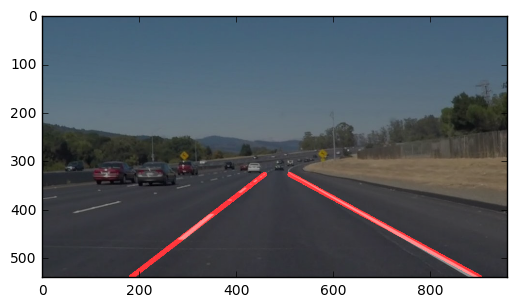

put_img_with_my_file: Full output path is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\transformed_images\solidWhiteCurve_lanes_found.jpg
file_guy: __next__: self.iter_file:  1  self.last_file:  5
file_guy: self.iter_file:  2  show_file:  1
file_guy: self.file_list[show_file]:  solidWhiteRight.jpg
do_processing: the input file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\solidWhiteRight.jpg
get_img_with_my_file: file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\solidWhiteRight.jpg
do_processing: File name:  solidWhiteRight.jpg  type:  <class 'numpy.ndarray'>  file facts: width, length:  (540, 960, 3)
do_processing: Processing completed for this file:  solidWhiteRight.jpg


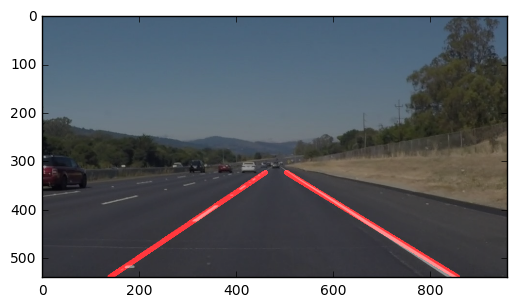

put_img_with_my_file: Full output path is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\transformed_images\solidWhiteRight_lanes_found.jpg
file_guy: __next__: self.iter_file:  2  self.last_file:  5
file_guy: self.iter_file:  3  show_file:  2
file_guy: self.file_list[show_file]:  solidYellowCurve.jpg
do_processing: the input file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\solidYellowCurve.jpg
get_img_with_my_file: file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\solidYellowCurve.jpg
do_processing: File name:  solidYellowCurve.jpg  type:  <class 'numpy.ndarray'>  file facts: width, length:  (540, 960, 3)
do_processing: Processing completed for this file:  solidYellowCurve.jpg


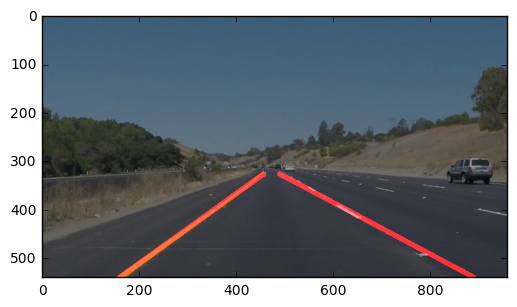

put_img_with_my_file: Full output path is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\transformed_images\solidYellowCurve_lanes_found.jpg
file_guy: __next__: self.iter_file:  3  self.last_file:  5
file_guy: self.iter_file:  4  show_file:  3
file_guy: self.file_list[show_file]:  solidYellowCurve2.jpg
do_processing: the input file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\solidYellowCurve2.jpg
get_img_with_my_file: file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\solidYellowCurve2.jpg
do_processing: File name:  solidYellowCurve2.jpg  type:  <class 'numpy.ndarray'>  file facts: width, length:  (540, 960, 3)
do_processing: Processing completed for this file:  solidYellowCurve2.jpg


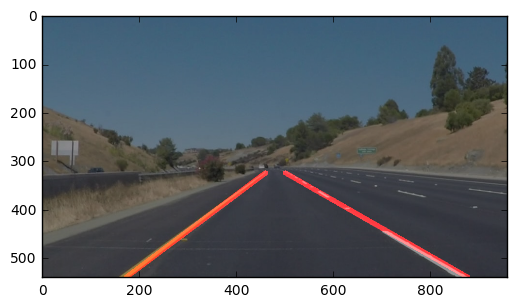

put_img_with_my_file: Full output path is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\transformed_images\solidYellowCurve2_lanes_found.jpg
file_guy: __next__: self.iter_file:  4  self.last_file:  5
file_guy: self.iter_file:  5  show_file:  4
file_guy: self.file_list[show_file]:  solidYellowLeft.jpg
do_processing: the input file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\solidYellowLeft.jpg
get_img_with_my_file: file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\solidYellowLeft.jpg
do_processing: File name:  solidYellowLeft.jpg  type:  <class 'numpy.ndarray'>  file facts: width, length:  (540, 960, 3)
do_processing: Processing completed for this file:  solidYellowLeft.jpg


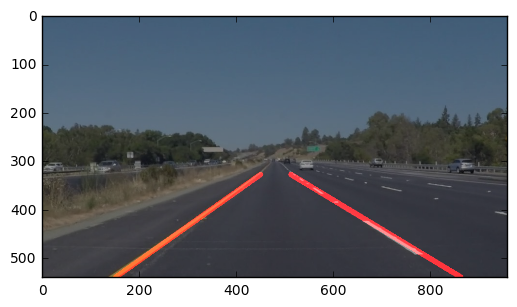

put_img_with_my_file: Full output path is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\transformed_images\solidYellowLeft_lanes_found.jpg
file_guy: __next__: self.iter_file:  5  self.last_file:  5
file_guy: self.iter_file:  6  show_file:  5
file_guy: self.file_list[show_file]:  whiteCarLaneSwitch.jpg
do_processing: the input file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\whiteCarLaneSwitch.jpg
get_img_with_my_file: file is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\test_images\whiteCarLaneSwitch.jpg
do_processing: File name:  whiteCarLaneSwitch.jpg  type:  <class 'numpy.ndarray'>  file facts: width, length:  (540, 960, 3)
do_processing: Processing completed for this file:  whiteCarLaneSwitch.jpg


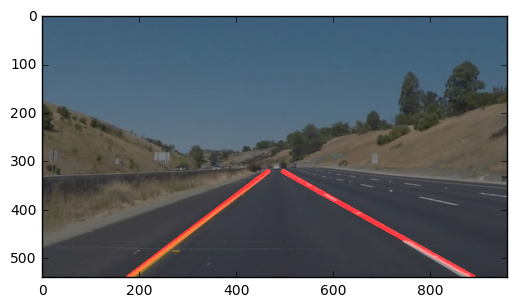

put_img_with_my_file: Full output path is:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\transformed_images\whiteCarLaneSwitch_lanes_found.jpg
file_guy: __next__: self.iter_file:  6  self.last_file:  5


In [10]:
def main():
    # test the code written to ensure it actually works.
    road_img_path = "test_images\\"
    driving_img_path = "transformed_images\\"
    working_dir = os.path.abspath(os.getcwd())+"\\"
    
    try:
        # *** print ("Starting in: ",os.path.abspath(os.getcwd()))
        
        # First verify the file handler will extract the list of files correctly
        my_files = file_guy()
        process_file = process_image()
        
        """ testing for failure::my_files.set_path("frangible", road_img_path) """
        my_files.init_path("input", working_dir + road_img_path)
        my_files.init_path("output", working_dir + driving_img_path)
        
        # verify code functionality
        # *** print("Current working directory: ", os.path.abspath(os.getcwd()))
        # *** print("Input dir: ", my_files.get_input_path())
        # *** print("Output dir: ", my_files.get_output_path())
        
        my_files.init_input_file_list()
        print("main: file list is: ",my_files.get_file_list())
        
        for a_file in iter(my_files):
            #
            # process the files in the file list.  Save the results to the output directory
            #
            print ("do_processing: the input file is: ", my_files.get_input_path() + a_file)
            #
            # get the marked up file 
            #
            marked_up_file = process_file.do_processing(a_file, my_files)
            #
            # Time to write this file out!
            #
            put_img_with_my_file(marked_up_file, a_file, my_files)

    except (SDCND_InvalidInput):
        print("main: Hit Invalid Input error")

    except (OSError):
        print ("main: Hit OSError")
    
    except (IOError):
        print ("main: Hit IOError")
    
    except (StopIteration):
        print("main: done processing file list")
    

main()



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
#def process_video_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # BjH: Having originally created my processing function as a CLASS which accepted inputs 
    # from a file handling class, I will now retool my image processing logic to handle the video image.
    # Borrowing from my class definition, I will establish the same type of settings, and then functionalize
    # the result to minimize the work I have to do to get this thing done!
    # I do not like coding it this way, but for right now the project is super late and will be horribly 
    # coded in exchange for getting it done.
    #
#    print("process_video_image: showing image received")
#    plt.imshow(image)
#    plt.show()
#    print("process_video_image: image has been shown")
#    result = 2
#    return image

# Here is the processing part
class process_video_image():    
    # Handle the image processing steps
    #
    
    def __init__(self):
        self.kernel_size = 11  # was originally 11 in the quizzes
        self.low_threshold = 55 # was originally 55 in the quizzes
        self.high_threshold = 150
        
    def do_processing(self, img):
        # run through the processing for a file, writing out the file to the destination
        # directory when done.
        try:
            # read in and show the image and some of its properties
            print("process_video_image: do_processing: about to start image: ")
            plt.imshow(img)
            plt.show()
            start_image = get_img(img)

            # convert to gray
            # *** print ("do_processing: Convert to gray")
            gray_image = grayscale (start_image)

            # Apply a Gaussian blur
            blurred_image = gaussian_blur(gray_image, self.kernel_size)
            # *** print ("do_processing: Blurred file")
            
            # Find the edges
            edgy_image = canny(blurred_image, self.low_threshold, self.high_threshold)
            # *** print ("do_processing: Edgy file")
            
            # Mask the image
            masked_image = masker(edgy_image)
            # *** print ("do_processing: Masked file")
            
            # Use the Hough transform to locate points of interest
            # and then draw the colored lines 
            marked_image = hough_lines(masked_image, start_image)
            # *** print ("do_processing: Marked (HoughLines) file")
            # *** plt.imshow(marked_image)
            """
            
            # Create a color binary to combine with the line image
            # !!!!! Red herring here - this step does not do what I had expected
            # and does not seem at all necessary!
            # color_edges = np.dstack((edgy_image, edgy_image, edgy_image))
            # print ("do_processing: Colored edges")
            # plt.imshow(color_edges)
            """
            # Combine them up
            final_img = weighted_img(marked_image, start_image)
            print("do_processing: Processing completed for this frame: ", img)
            plt.imshow(final_img)
            plt.show()
                        
        except OSError:
            print ("do_processing: OSError encountered")
        except:
            print ("do_processing: Other error occured")
        else:
            # *** print ("managed to reach the finish line!")
            return (final_img)


Let's try the one with the solid white lane on the right first ...

Currently in:  C:\Users\Barbara\Udacity_Development\SDCND_P1_FindingLanes\CarND-LaneLines-P1\
process_video_image: do_processing: about to start image: 


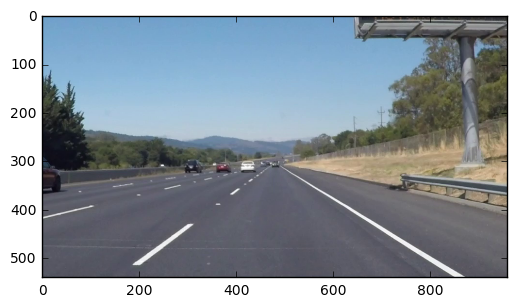

do_processing: Other error occured


AttributeError: 'NoneType' object has no attribute 'shape'

In [17]:
my_process = process_video_image()
print("Currently in: ", os.path.abspath(os.getcwd())+"\\")
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(my_process.do_processing) #NOTE: this function expects color images!! and it applies a lambda
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


In [ ]:
One weakness of this code is the reliance on clear pictures.  What happens in rain, fog, snow, and icy conditions?  How does
the night view within the headlights work?  Also back roads are notorious for lack of lines and presence of all sorts of 
deviances in appearance. 

The assumption is the camera (POV) is always the same framing.  It would be interesting to see if the camera moved to different
locations in the vehicle, would it impact this solution?  

Severely curved path traversal may well not be properly calculated as the current algorithm seems to be tuned to straight lines.

Dirt roads would be difficult as well, completely lacking obvious lane lines. These would probably require a different
algorithm for finding the safe way forward, probably something that would compute the flattest plan in the near horizon.  

Also, the pictures are all assumed to be a view of a straight ahead picture, without any large lane obstruction such as a 
random car, deer, or pedestrian.  Currently there is no rationale to identify a failed forward path.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
Unfortunately, at this time I am so far behind, I cannot take the time to accept this challenge. :(

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))